<a href="https://colab.research.google.com/github/gut-puncture/Compound_Embedding_Reasoning/blob/main/Compound_Embedding_Reasoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive') # connecting google drive to this notebook

!pip -q install --upgrade "transformers==4.41.2" "accelerate>=0.29.0" \
                "sentencepiece" "datasets" "pandas" "matplotlib" "huggingface_hub>=0.23.0"

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 135.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

##Inference

In [2]:
import torch, re, math, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import random, textwrap

# ---------- paths ---------------------------------------------------------
MODEL_DIR           = "/content/drive/MyDrive/phi3_3.8B"   # NEED THIS MODEL TO BE PRESENT IN GOOGLE DRIVE
BASELINE_HF_MODEL   = "microsoft/phi-3-mini-4k-instruct"   # reference

# ---------- thinking parameters ------------------------------------------
ALPHA               = 0.2
COMPOUND_P          = 0.7
SAMPLE_P            = 0.80
STOP_INV_PPL_AVG    = 1.02
WINDOW              = 10
MAX_THINK_STEPS     = 200
MIN_THINK_STEPS     = 80   # Minimum steps before allowing reasoning end token to stop

# ---------- token markers -------------------------------------------------
REASON_START = "### Reasoning:\n"
REASON_END   = "###"
ANS_START    = "### Answer:\n"

DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE   = torch.float16 if DEVICE == "cuda" else torch.float32

#Helper Functions - New

In [3]:
def create_compound_vector(model_outputs, embeddings, dtype, p=COMPOUND_P):
    logits = model_outputs.logits[:, -1, :]
    probs  = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    cum    = torch.cumsum(sorted_probs, dim=-1)
    mask   = cum <= p #all elements with cumulative prob less than p are True and all others False in mask
    mask[..., 0] = True #first element is hard coded to True so we ALWAYS choose at least one element
    sel_idx, sel_prob = sorted_idx[mask], sorted_probs[mask] #selecting all the token ids and their probs for which cumulative prob is less than p

    # FIXED: Normalize the probabilities so they sum to 1
    weights = sel_prob / sel_prob.sum()
    vec = (embeddings(sel_idx) * weights.unsqueeze(-1)).sum(0, keepdim=True)
    return vec.to(dtype).unsqueeze(0)

def sample_token_normally(model_outputs, p=SAMPLE_P): #essentially the same function as above but gives just the sampled token id
    logits = model_outputs.logits[:, -1, :]
    probs  = torch.softmax(logits, dim=-1)
    sorted_probs, sorted_idx = torch.sort(probs, descending=True)
    mask   = torch.cumsum(sorted_probs, dim=-1) <= p
    mask[..., 0] = True

    # FIXED: Normalize probabilities before sampling
    selected_probs = sorted_probs[mask]
    normalized_probs = selected_probs / selected_probs.sum()
    choice = torch.multinomial(normalized_probs, 1)
    return sorted_idx[mask][choice]

def create_thinking_vector(comp_vec, samp_tok, embeddings, dtype, alpha=ALPHA):
    samp_emb = embeddings(samp_tok).unsqueeze(0).to(dtype)
    return (1-alpha)*samp_emb + alpha*comp_vec.to(dtype) #creating a weigthed sum of the sampled token vector and the compound vector

class ThinkGenerator: #Completely AI written
    """
    Callable: prompt -> (answer_text, steps, inv_ppl_list, entropy_list)
    """
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        self.model     = AutoModelForCausalLM.from_pretrained(
                            model_path, torch_dtype=DTYPE, device_map="auto")
        self.embed     = self.model.model.embed_tokens
        self.dtype     = next(self.model.parameters()).dtype
        self.device    = next(self.model.parameters()).device

    @torch.inference_mode()
    def __call__(self, full_prompt:str):
        ids   = self.tokenizer(full_prompt, return_tensors="pt").input_ids.to(self.device) #converts string to tokens
        embeds = self.embed(ids).to(self.dtype) #embeddings of the token ids
        inv_hist, ent_hist = [], []

        # Get the token ID for the CoT end marker "###"
        reason_end_token_id = self.tokenizer.encode(REASON_END, add_special_tokens=False)[0]
        reason_end_already_added = False  # FIXED: Track if we already added the end token
        stopping_reason = "max_steps"  # Default stopping reason

        # Reasoning loop for model
        # STOPPING CONDITIONS (ALL require minimum MIN_THINK_STEPS):
        # 1. Inverse perplexity condition is met (avg of last WINDOW steps < STOP_INV_PPL_AVG) AND min steps completed
        # 2. Reasoning end token "###" is sampled AND minimum MIN_THINK_STEPS completed
        # 3. Maximum reasoning steps (MAX_THINK_STEPS) reached
        for step in range(MAX_THINK_STEPS):
            # FIXED: Add proper attention mask for inputs_embeds
            attention_mask = torch.ones(embeds.size()[:2], device=embeds.device)
            outs   = self.model(inputs_embeds=embeds, attention_mask=attention_mask) #vector embeddings injected in model rather than token ids
            logits = outs.logits[:, -1, :]
            p      = torch.softmax(logits, dim=-1)
            inv_hist.append(1 / p.max().item()) #history of inverse perplexity which is essentially reciprocal of top token prob
            ent_hist.append(-(p * p.log()).sum().item())

            # FIXED: Enforce minimum steps for ALL stopping conditions
            #if average of last n elements is greater than the threshold AND minimum steps completed, we stop this loop
            if (len(inv_hist) >= WINDOW and
                sum(inv_hist[-WINDOW:])/WINDOW < STOP_INV_PPL_AVG and
                step >= MIN_THINK_STEPS):
                # FIXED: Add reasoning end token when stopping due to inv-ppl condition
                reason_end_tok = torch.tensor([[reason_end_token_id]], device=self.device)
                plain_emb = self.embed(reason_end_tok).to(self.dtype)
                embeds = torch.cat([embeds, plain_emb], 1)
                ids = torch.cat([ids, reason_end_tok], 1)
                reason_end_already_added = True
                stopping_reason = "inverse_perplexity"
                break

            comp = create_compound_vector(outs, self.embed, self.dtype)
            tok  = sample_token_normally(outs)

            # FIXED: Check if the sampled token is the CoT end marker "###"
            # BUT only allow exit if minimum MIN_THINK_STEPS are completed
            if tok.item() == reason_end_token_id and step >= MIN_THINK_STEPS:
                # FIXED: Add plain embedding (no compound mixing) since reasoning is ending
                # and set flag to avoid duplicate "###" later
                plain_emb = self.embed(tok).unsqueeze(0).to(self.dtype)
                embeds = torch.cat([embeds, plain_emb], 1)
                ids    = torch.cat([ids, tok.unsqueeze(0)], 1)
                reason_end_already_added = True
                stopping_reason = "sampled_end_token"
                break
            elif tok.item() == reason_end_token_id and step < MIN_THINK_STEPS:
                # If end token is sampled before minimum steps, treat it as a regular token and continue
                vec = create_thinking_vector(comp, tok, self.embed, self.dtype)
                embeds = torch.cat([embeds, vec], 1)
                ids = torch.cat([ids, tok.unsqueeze(0)], 1)
                continue

            vec  = create_thinking_vector(comp, tok, self.embed, self.dtype)
            embeds = torch.cat([embeds, vec], 1) #adding the compound vector to the previous token vectors
            ids    = torch.cat([ids, tok.unsqueeze(0)], 1)

        # FIXED: Ensure reasoning end token is always added if we exit due to max steps
        if not reason_end_already_added:
            reason_end_tok = torch.tensor([[reason_end_token_id]], device=self.device)
            plain_emb = self.embed(reason_end_tok).to(self.dtype)
            embeds = torch.cat([embeds, plain_emb], 1)
            ids = torch.cat([ids, reason_end_tok], 1)
            reason_end_already_added = True
            stopping_reason = "max_steps"

        # FIXED: Conditional delimiter to avoid duplicate "###"
        if reason_end_already_added:
            # Only add the answer start part since "###" is already there
            delim_text = f"\n{ANS_START}"
        else:
            # Add both end and answer start
            delim_text = f"{REASON_END}\n{ANS_START}"

        delim = self.tokenizer(delim_text, add_special_tokens=False, return_tensors="pt").input_ids.to(self.device)
        delim_embeds = self.embed(delim).to(self.dtype)

        # FIXED: Concatenate delimiter embeddings and IDs to maintain compound context
        embeds = torch.cat([embeds, delim_embeds], 1)
        ids = torch.cat([ids, delim], 1)

        # FIXED: Use both input_ids and inputs_embeds to preserve full context while using compound embeddings
        attention_mask = torch.ones_like(ids)
        gen = self.model.generate(
            input_ids=ids,
            inputs_embeds=embeds,
            attention_mask=attention_mask,
            max_new_tokens=50,
            do_sample=False,
            pad_token_id=self.tokenizer.eos_token_id
        )
        text = self.tokenizer.decode(gen[0])
        return text, len(inv_hist), inv_hist, ent_hist, stopping_reason


#Main Loop

In [4]:
# Add 8 few-shot examples so we can compare performace with 8 shot eval
FEW_SHOT_BLOCK = """
Example Questions and Answers:
Question: If you roll 2 standard six-sided dice, what is the probability that the sum is 5?
### Reasoning:
The pairs that sum to 5 are (1,4), (2,3), (3,2), (4,1).\
There are 4 favourable outcomes out of 36 total. Probability = 4/36 = 1/9.
###
### Answer:
1/9

Question: A rectangle has length 8 cm and width 5 cm. What is its area in square centimetres?
### Reasoning:
Area = length × width = 8 × 5 = 40 cm².
###
### Answer:
40

Question: Sarah has 3 red, 4 blue, and 5 green marbles. If she randomly chooses one, what is the probability it is blue?
### Reasoning:
Total marbles = 3+4+5 = 12. Blue count = 4. Probability = 4/12 = 1/3.
###
### Answer:
1/3

Question: What is 15 % of 80?
### Reasoning:
0.15 × 80 = 12.
###
### Answer:
12

Question: A train travels 180 km in 3 hours. What is its average speed in km per hour?
### Reasoning:
Speed = distance / time = 180 / 3 = 60 km/h.
###
### Answer:
60

Question: The number x satisfies 3x + 7 = 22. What is x?
### Reasoning:
3x = 22 − 7 = 15 ⇒ x = 15/3 = 5.
###
### Answer:
5

Question: A square has perimeter 24 cm. What is the length of one side in centimetres?
### Reasoning:
Perimeter = 4s ⇒ s = 24/4 = 6 cm.
###
### Answer:
6

Question: Mike scores 70, 80, 90 on three tests. What average must he score on a 4th test to have a mean of 85?
### Reasoning:
Desired total = 85×4 = 340. Current total = 70+80+90 = 240. Needed = 340−240 = 100.
###
### Answer:
100
""".strip()

SYSTEM_PROMPT = """You are an AI model which is being evaluated to see how well you're able to solve few reasoning questions which all have integer answers.
From the next line, I have given you a few examples of the kind of questions you can expect, how you must reason to solve them and how to answer.
Then you will see the words "Test Question" which will be the question you need to answer in the test.
Think between the reasoning tokens and then write the answer. You must always end the reasoning with the token "###" but only and only when you're ready to provide the answer.
Once you're done with reasoning, you can provide the answer.
The first integer after "### Answer:\n" in your generation will be what I will take as your answer and if it doesn't match with the answer given, I will give you 0 reward.
Even more important is to simply answer just the test question and stop generating tokens after the integer answer. """


In [5]:
import random, textwrap

gsm_test  = load_dataset("gsm8k", "main", split="test").shuffle(seed=21).select(range(500))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [6]:

tok_base  = AutoTokenizer.from_pretrained(BASELINE_HF_MODEL, trust_remote_code=True)
mod_base  = AutoModelForCausalLM.from_pretrained(BASELINE_HF_MODEL,
                                                 torch_dtype=DTYPE, device_map="auto")

think_gen = ThinkGenerator(MODEL_DIR)

def build_prompt(question: str) -> str:
    return f"{SYSTEM_PROMPT}\n{FEW_SHOT_BLOCK}\n\n Test Question: {question}\n{REASON_START}"

def gold_int(ans: str) -> str:
    ints = re.findall(r"-?\d+", ans)
    return ints[-1] if ints else "" #results in the final integer in the model's generation

# Use the better answer extraction function
def extract_first_answer_integer(text: str, question: str) -> str:
    """
    Extract the first integer that appears after the FIRST occurrence of '### Answer:'
    that follows the given question. This prevents picking up integers from
    subsequent generated questions.
    """
    # First, find where the question appears
    if question in text:
        # Get text after the question
        text_after_q = text.split(question, 1)[1]

        # Find the first "### Answer:" after the question
        if ANS_START in text_after_q:
            answer_section = text_after_q.split(ANS_START, 1)[1]

            # Extract the first integer from this answer section
            # But stop at the next "Question:" if there is one.
            #This is added because earlier the model would generate questions,reasoning and answers by itself in a single generation
            next_q_pos = answer_section.find("Question:")
            if next_q_pos != -1: #means Question: wasn't found in the answer_section
                answer_section = answer_section[:next_q_pos]

            # Find the first integer
            matches = re.findall(r"-?\d+", answer_section)
            if matches:
                return matches[-1]

    # Fallback: if we can't find the pattern, look for first answer section
    if ANS_START in text:
        parts = text.split(ANS_START)
        if len(parts) > 1:
            # Look at first answer section only
            first_answer = parts[1]
            next_q_pos = first_answer.find("Question:")
            if next_q_pos != -1:
                first_answer = first_answer[:next_q_pos]
            matches = re.findall(r"-?\d+", first_answer)
            if matches:
                return matches[-1]

    # Last resort: find any integer in the text
    matches = re.findall(r"-?\d+", text)
    return matches[-1] if matches else ""

@torch.inference_mode()
def baseline_answer(question: str) -> (str, str):
    prompt = build_prompt(question)
    ids    = tok_base(prompt, return_tensors="pt").input_ids.to(DEVICE)
    gen    = mod_base.generate( #answer generate by vanilla model for comparison. we defined the vanilla model's name and simply use that.
                ids,
                max_new_tokens=256,
                do_sample=False,
                attention_mask=torch.ones_like(ids),
                pad_token_id=tok_base.eos_token_id
            )
    text = tok_base.decode(gen[0])
    return text, extract_first_answer_integer(text, question)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Test Run

In [ ]:
##############################################################################
### SANITY-CHECK CELL – run 5 questions first                             ###
##############################################################################

NUM_SANITY = 5
sample_question_idxs = random.sample(range(len(gsm_test)), NUM_SANITY)


for k, idx in enumerate(sample_question_idxs, 1):
    q_raw  = gsm_test[idx]["question"]         #question string
    gold   = gold_int(gsm_test[idx]["answer"]) #answer extracted from the question string. it's always the last integer.

    print("="*70, f"\nSAMPLE {k}\nQuestion:\n{textwrap.fill(q_raw, 68)}")
    print("Gold answer:", gold, "\n")

    # baseline
    base_text, base_num = baseline_answer(q_raw) #vanilla model generates response with the question
    print("--- BASELINE RAW (tail) ---\n", base_text[-400:], "\n") #printing last 400 characters of the vanilla model's response to the question
    print("Parsed integer  →", base_num)  #answer from vanilla model extracted

    # think-advance
    think_text, steps, inv, ent, stop_reason = think_gen(build_prompt(q_raw))
    think_num = extract_first_answer_integer(think_text, q_raw)
    print("--- THINK RAW (tail) ---\n", think_text[:], "\n") #CHANGED THIS TO PRINT ALL CHARACTERS TO SEE. CHANGE TO -400:0
    print("Parsed integer  →", think_num)
    print("Thinking steps  →", steps,
          "  inv-ppl avg →", f"{sum(inv)/len(inv):.3f}",
          "  stop reason →", stop_reason)
    print("\n\n")

# Eval

In [7]:
# Full evaluation on 500 questions
print("Running full evaluation on 500 questions...\n")

rows = []
for i, ex in enumerate(gsm_test):
    if i % 50 == 0:
        print(f"Processing question {i}/500...")

    q_raw, gold_raw = ex["question"], ex["answer"]
    gold_num = gold_int(gold_raw)

    # Get baseline answer
    base_text, base_num = baseline_answer(q_raw)

    # Get thinking model answer
    think_text, steps, inv, ent, stop_reason = think_gen(build_prompt(q_raw))
    think_num = extract_first_answer_integer(think_text, q_raw)  # Use better function

    rows.append({
        "id": i,
        "question": q_raw,
        "gold": gold_num,
        "baseline_int": base_num,
        "think_int": think_num,
        "correct_baseline": base_num == gold_num,
        "correct_think": think_num == gold_num,
        "steps": steps,
        "inv_ppl_avg": sum(inv)/len(inv) if inv else 0,
        "entropy_avg": sum(ent)/len(ent) if ent else 0,
        "stopping_reason": stop_reason,
        "baseline_raw": base_text.split("Test Question:", 1)[-1].replace("\n", " \\n "),
        "think_raw": think_text.split("Test Question:", 1)[-1].replace("\n", " \\n ")
    })

df = pd.DataFrame(rows)
df.to_csv("/content/drive/MyDrive/gsm8k_think_metrics_fixed.csv", index=False)
print("\nEvaluation complete!")

Running full evaluation on 500 questions...

Processing question 0/500...


You are not running the flash-attention implementation, expect numerical differences.


Processing question 50/500...
Processing question 100/500...
Processing question 150/500...
Processing question 200/500...
Processing question 250/500...
Processing question 300/500...
Processing question 350/500...
Processing question 400/500...
Processing question 450/500...

Evaluation complete!



Baseline φ-3 accuracy on 500 GSM-8K questions: 58.00%
Think-advance model accuracy: 50.40%
Improvement: -7.60% (-13.1% relative)



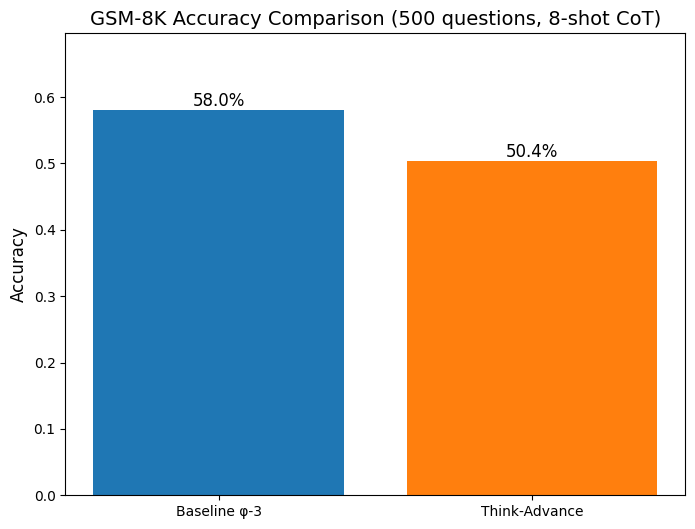

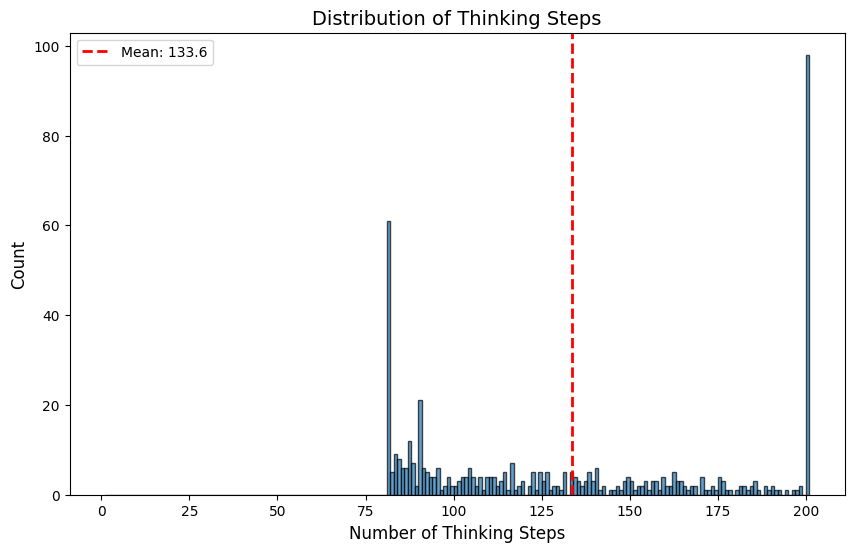


Found 83 cases where thinking model got it right but baseline didn't.
Example:
Question: A factory used to make tractors, but now makes silos. When they made tractors, they sold 10 tractors...
Gold: 10
Baseline: 5
Think: 10
Think steps: 183

Results saved to: /content/drive/MyDrive/gsm8k_think_metrics_fixed.csv


In [8]:
# Results Analysis and Visualization
base_acc = df["correct_baseline"].mean()
think_acc = df["correct_think"].mean()

print(f"\n" + "="*50)
print(f"Baseline φ-3 accuracy on 500 GSM-8K questions: {base_acc:.2%}")
print(f"Think-advance model accuracy: {think_acc:.2%}")
print(f"Improvement: {(think_acc - base_acc):.2%} ({(think_acc/base_acc - 1)*100:.1f}% relative)")
print("="*50 + "\n")

# Accuracy comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(["Baseline φ-3", "Think-Advance"], [base_acc, think_acc],
                color=['#1f77b4', '#ff7f0e'])
plt.title("GSM-8K Accuracy Comparison (500 questions, 8-shot CoT)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, max(base_acc, think_acc) * 1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontsize=12)
plt.show()

# Thinking steps distribution
plt.figure(figsize=(10, 6))
plt.hist(df["steps"], bins=range(1, MAX_THINK_STEPS+2), alpha=0.7, edgecolor='black')
plt.title("Distribution of Thinking Steps", fontsize=14)
plt.xlabel("Number of Thinking Steps", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.axvline(df["steps"].mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {df["steps"].mean():.1f}')
plt.legend()
plt.show()

# Show some examples where thinking helped
think_better = df[(df["correct_think"] == True) & (df["correct_baseline"] == False)]
if len(think_better) > 0:
    print(f"\nFound {len(think_better)} cases where thinking model got it right but baseline didn't.")
    print("Example:")
    ex = think_better.iloc[0]
    print(f"Question: {ex['question'][:100]}...")
    print(f"Gold: {ex['gold']}")
    print(f"Baseline: {ex['baseline_int']}")
    print(f"Think: {ex['think_int']}")
    print(f"Think steps: {ex['steps']}")

print(f"\nResults saved to: /content/drive/MyDrive/gsm8k_think_metrics_fixed.csv")

In [ ]:
df.to_csv("/content/drive/MyDrive/gsm8k_think_metrics_fixed.csv", index=False)